# 1) Import Necessary Libraries

In [1]:
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

## 2) Remove Duplicated GPS Entries

In [2]:
def remove_duplicates(GPS_Data):
    # Apply the filter
    GPS_Data = GPS_Data[~GPS_Data.duplicated(subset=['Hashed_ID','Unix_Time'])]

    return GPS_Data

#GPS_Data = remove_duplicates(GPS_Data = GPS_Data)

## 3) Remove Rows with NaN in key columns 

In [3]:
def remove_nan(GPS_Data):
     # Apply the filter
    GPS_Data = GPS_Data[~GPS_Data[['Hashed_ID','lat','lon','Unix_Time']].isna().any(axis=1)]

    return GPS_Data

#GPS_Data = remove_nan(GPS_Data = GPS_Data)

## 4) Find time in seconds between GPS data points

In [4]:
def find_time(GPS_Data):
    GPS_Data.loc[:, "dt"] = GPS_Data.groupby("Hashed_ID")["Unix_Time"].diff()

    return GPS_Data

#GPS_Data = find_time(GPS_Data = GPS_Data)

## 5) Find distance in meters between GPS data points

In [5]:
def find_distances(GPS_Data):
    # Convert lat/lon to radians
    lat_rad = np.radians(GPS_Data["lat"].values)
    lon_rad = np.radians(GPS_Data["lon"].values)
    ids = GPS_Data["Hashed_ID"].values

    # Shift arrays to get previous point
    lat_prev = np.roll(lat_rad, 1)
    lon_prev = np.roll(lon_rad, 1)
    id_prev = np.roll(ids, 1)

    # Compute differences
    dlat = lat_rad - lat_prev
    dlon = lon_rad - lon_prev

    # Haversine formula
    R = 6371000  # Earth radius in meters
    a = np.sin(dlat / 2)**2 + np.cos(lat_prev) * np.cos(lat_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distances = R * c

    # Set distances to NaN for first point of each trajectory
    distances[ids != id_prev] = np.nan
    distances[0] = np.nan  # first row overall

    # Assign to DataFrame
    GPS_Data.loc[:, "dist_m"] = distances

    return GPS_Data

#GPS_Data = find_distances(GPS_Data = GPS_Data)

# 6) Find speed in meters per second 

In [6]:
def find_speed(GPS_Data):
    GPS_Data.loc[:, "speed"] = GPS_Data.loc[:, "dist_m"] / GPS_Data.loc[:, "dt"]

    return GPS_Data

#GPS_Data = find_speed(GPS_Data = GPS_Data)

## 7) Find acceleration 

In [7]:
def find_acceleration(GPS_Data):
    GPS_Data.loc[:, "accel"] = GPS_Data.groupby("Hashed_ID")["speed"].diff() / GPS_Data.loc[:, "dt"]

    return GPS_Data

#GPS_Data = find_acceleration(GPS_Data = GPS_Data)

## 8) Remove GPS data points with impossible values

In [8]:
def remove_impossible_values(GPS_Data):
    # Apply the filter
    GPS_Data = GPS_Data[((GPS_Data["speed"].between(0, 40)) | GPS_Data["speed"].isna()) &
        ((GPS_Data["accel"].between(-10, 10)) | GPS_Data["accel"].isna()) &
        ((GPS_Data["dt"] >= 0) | GPS_Data["dt"].isna())]
    
    return GPS_Data

#GPS_Data = remove_impossible_values(GPS_Data = GPS_Data)

## 9) Find trajectories of GPS data

In [9]:
def filter_trajectories_mean_filt(GPS_Data, min_traj_size, gap_minutes, mean_res_mins):
    gap_seconds = gap_minutes * 60
    mean_resolution_seconds = mean_res_mins * 60

    GPS_Data["large_gap"] = GPS_Data["dt"] >= gap_seconds

    # Compute trajectory group (cumulative sum per user) in place
    GPS_Data["traj_group"] = GPS_Data.groupby("Hashed_ID")["large_gap"].cumsum()

    # Compose traj_id in place
    GPS_Data["traj_id"] = GPS_Data["Hashed_ID"].astype(str) + "_" + GPS_Data["traj_group"].astype(str)

    # Prepare dt for median calculation (ignore dt <= 0)
    dt_valid = GPS_Data["dt"].where(GPS_Data["dt"] > 0)

    # Compute median per trajectory (vectorized)
    median_dt_per_traj = dt_valid.groupby(GPS_Data["traj_id"]).mean()

    # Map median back to each row
    GPS_Data["median_dt"] = GPS_Data["traj_id"].map(median_dt_per_traj)

    # Keep only high-resolution segments
    GPS_Data = GPS_Data[GPS_Data["median_dt"] <= mean_resolution_seconds]

    # Filter small trajectories
    counts = GPS_Data["traj_id"].value_counts()
    keep_traj_ids = counts[counts >= min_traj_size].index

    filtered_gdf = GPS_Data[GPS_Data["traj_id"].isin(keep_traj_ids)]
    
    return filtered_gdf

def filter_trajectories(GPS_Data, min_traj_size, gap_minutes):
    gap_seconds = gap_minutes * 60

    # Start a new trajectory whenever the gap is too large
    GPS_Data["traj_group"] = (
        (GPS_Data["dt"] >= gap_seconds).astype(int)
        .groupby(GPS_Data["Hashed_ID"])
        .cumsum() )

    # Full trajectory ID
    GPS_Data.loc[:, "traj_id"] = GPS_Data["Hashed_ID"].astype(str) + "_" + GPS_Data["traj_group"].astype(str)

    # Keep only trajectories with >= min_traj_size points
    counts = GPS_Data["traj_id"].value_counts()
    keep_ids = counts[counts >= min_traj_size].index

    filtered_gdf = GPS_Data[GPS_Data["traj_id"].isin(keep_ids)]

    return filtered_gdf

#filtered_gdf = filter_trajectories(GPS_Data = GPS_Data, min_traj_size = 10, gap_minutes = 10)

## 10) Recalculated Metrics on filtered GPS data

Identical to the above code - sections 4 to 8 - but completed on the filtered dataset.

Decide if to rerun trajectory filtering based on number of removed points

In [10]:
def recalculate_characteristics(GPS_Data):
    GPS_Data = find_time(GPS_Data = GPS_Data)

    GPS_Data = find_distances(GPS_Data = GPS_Data)

    GPS_Data = find_speed(GPS_Data = GPS_Data)

    GPS_Data = find_acceleration(GPS_Data = GPS_Data)

    GPS_Data = remove_impossible_values(GPS_Data = GPS_Data)

    return GPS_Data
    
#filtered_gdf = recalculate_characteristics(GPS_Data = filtered_gdf)

# 11) Master Pipeline to Run Code Over Entire GPS Dataset

In [11]:
start_full = time.time()

min_trajectory = 10
min_gap_length = 6
mean_traj_time = 2

GPS_Sum = pd.read_csv('GPS_Data/Hashed_ID_Summary.csv')
GPS_Sum['percent_kept'] = 0.0
GPS_Sum['rows_raw'] = 0
GPS_Sum['rows_clean'] = 0
GPS_Sum['traj_num'] = 0

chunk_folder = "GPS_Data/Chunks"
output_folder = "GPS_Data/Chunks_Preprocessed/"
chunk_files = sorted(glob.glob(os.path.join(chunk_folder, "GPS_Data_Chunk_*.tsv")))

for chunk_file in chunk_files:

    start = time.time()
    GPS_Data = pd.read_csv(chunk_file, sep='\t')

    # RAW COUNT
    raw_df = (
        GPS_Data.groupby("Hashed_ID")
        .size().reset_index(name="rows_raw_chunk")
    )

    # Preprocessing GPS Data
    GPS_Data = remove_duplicates(GPS_Data)
    GPS_Data = remove_nan(GPS_Data)
    GPS_Data = find_time(GPS_Data)
    GPS_Data = find_distances(GPS_Data)
    GPS_Data = find_speed(GPS_Data)
    GPS_Data = find_acceleration(GPS_Data)
    GPS_Data = remove_impossible_values(GPS_Data)

    #filtered_gdf = filter_trajectories(GPS_Data,
    #   min_traj_size=min_trajectory, gap_minutes=min_gap_length)
    
    filtered_gdf = filter_trajectories_mean_filt(GPS_Data = GPS_Data, 
                                                 min_traj_size = min_trajectory, 
                                                 gap_minutes = min_gap_length, 
                                                 mean_res_mins = mean_traj_time)

    filtered_gdf = recalculate_characteristics(filtered_gdf)

    # Exstract Hash_ID characteristics to a csv
    clean_df = (
        filtered_gdf.groupby("Hashed_ID")
        .size().reset_index(name="rows_clean_chunk")
    )

    traj_df = (
        filtered_gdf.groupby("Hashed_ID")["traj_id"]
        .nunique().reset_index(name="traj_num_chunk")
    )

    merged = (
        raw_df.merge(clean_df, on="Hashed_ID", how="left")
              .merge(traj_df, on="Hashed_ID", how="left")
              .fillna(0)
    )

    # Align with GPS_Sum
    tmp = GPS_Sum.merge(merged, on="Hashed_ID", how="left")

    GPS_Sum["rows_raw"] += tmp["rows_raw_chunk"].fillna(0)
    GPS_Sum["rows_clean"] += tmp["rows_clean_chunk"].fillna(0)
    GPS_Sum["traj_num"] += tmp["traj_num_chunk"].fillna(0)
    GPS_Sum["percent_kept"] = (
        GPS_Sum["rows_clean"] / GPS_Sum["rows_raw"] * 100
    ).round(2)

    # SAVE CLEANED CHUNK
    digits = [char for char in chunk_file if char.isdigit()]
    chunk_num = int("".join(digits))
    output_path = os.path.join(output_folder, f"GPS_Data_Chunk_Cleaned_{chunk_num}.tsv")
    filtered_gdf.to_csv(output_path, sep='\t', index=False)

    # TIME LOGGING
    print(f"GPS_Data_Chunk_{chunk_num} took {time.time()-start:.2f} seconds")

# FINAL SAVE
GPS_Sum.to_csv("GPS_Data/Hashed_ID_Summary2.csv", index=False)

# TOTAL TIME
elapsed = time.time() - start_full
m, s = divmod(elapsed, 60)
print(f"Total time: {int(m)}m {s:.1f}s")

GPS_Data_Chunk_1 took 10.33 seconds
GPS_Data_Chunk_10 took 11.17 seconds
GPS_Data_Chunk_100 took 10.60 seconds
GPS_Data_Chunk_101 took 11.01 seconds
GPS_Data_Chunk_102 took 10.07 seconds
GPS_Data_Chunk_103 took 9.49 seconds
GPS_Data_Chunk_104 took 10.31 seconds
GPS_Data_Chunk_105 took 11.57 seconds
GPS_Data_Chunk_106 took 11.01 seconds
GPS_Data_Chunk_107 took 10.73 seconds
GPS_Data_Chunk_108 took 11.12 seconds
GPS_Data_Chunk_109 took 10.67 seconds
GPS_Data_Chunk_11 took 9.85 seconds
GPS_Data_Chunk_110 took 9.24 seconds
GPS_Data_Chunk_111 took 10.46 seconds
GPS_Data_Chunk_112 took 10.62 seconds
GPS_Data_Chunk_113 took 12.08 seconds
GPS_Data_Chunk_114 took 11.30 seconds
GPS_Data_Chunk_115 took 10.67 seconds
GPS_Data_Chunk_116 took 10.15 seconds
GPS_Data_Chunk_117 took 2.06 seconds
GPS_Data_Chunk_12 took 11.39 seconds
GPS_Data_Chunk_13 took 11.36 seconds
GPS_Data_Chunk_14 took 9.91 seconds
GPS_Data_Chunk_15 took 11.25 seconds
GPS_Data_Chunk_16 took 11.23 seconds
GPS_Data_Chunk_17 took 10.

## 12) Selection of Gap Length and GPS Trace Length for Full Data

In [23]:
start2 = time.time()

GPS_Data = pd.read_csv(f'Ferry_Road_Code/FerryRoadIntersect2019.csv')

len_raw = len(GPS_Data)

GPS_Data[['Hashed_ID', 'lon', 'lat', 'Unix_Time']] = GPS_Data[['Hashed Device ID', 'Longitude of Visit', 'Latitude of Visit', 'Unix Timestamp of Visit']]

GPS_Data = remove_duplicates(GPS_Data = GPS_Data)

GPS_Data = remove_nan(GPS_Data = GPS_Data)

GPS_Data = find_time(GPS_Data = GPS_Data)

GPS_Data = find_distances(GPS_Data = GPS_Data)

GPS_Data = find_speed(GPS_Data = GPS_Data)

GPS_Data = find_acceleration(GPS_Data = GPS_Data)

GPS_Data = remove_impossible_values(GPS_Data = GPS_Data)

gap_length = [1, 2, 3, 4, 5, 6, 8, 10, 15, 30, 60]
min_traj = [3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 35]

# Initialize empty list to collect results
results = []
iteration = 1

for traj in min_traj:
    for gap in gap_length:
        print(f'Loop number {iteration}')
        iteration += 1
        
        #filtered_gdf = filter_trajectories(GPS_Data = GPS_Data, 
        #                                min_traj_size = traj, 
        #                                gap_minutes = gap)

        filtered_gdf = filter_trajectories_mean_filt(GPS_Data = GPS_Data, 
                                           min_traj_size = traj, 
                                           gap_minutes = gap,
                                            mean_res_mins = 2)

        percent_gps = round(100*len(filtered_gdf) / len_raw, 2)

        traj_sizes = (
            filtered_gdf
            .groupby(['Hashed_ID', 'traj_id'])
            .size()
            .reset_index(name='num_points')
        )


        mean_length = traj_sizes['num_points'].mean()
        median_length = traj_sizes['num_points'].median()
        std_trajs = traj_sizes['num_points'].std()
        trajs = len(filtered_gdf.groupby(by=['Hashed_ID', 'traj_id']))
        
        # Append results as a dictionary
        results.append({
            'min_traj': traj,
            'gap_length': gap,
            'percentage_gps': percent_gps,
            'median_length': median_length,
            'mean_length': mean_length,
            'std_length': std_trajs,
            'Trajectories': trajs,
            'Num_GPS': len(filtered_gdf)
        })

# Convert results list to a DataFrame
percent_matrix = pd.DataFrame(results)

print(f"Code took {time.time() - start2} seconds to run the code")

Loop number 1
Loop number 2
Loop number 3
Loop number 4
Loop number 5
Loop number 6
Loop number 7
Loop number 8
Loop number 9
Loop number 10
Loop number 11
Loop number 12
Loop number 13
Loop number 14
Loop number 15
Loop number 16
Loop number 17
Loop number 18
Loop number 19
Loop number 20
Loop number 21
Loop number 22
Loop number 23
Loop number 24
Loop number 25
Loop number 26
Loop number 27
Loop number 28
Loop number 29
Loop number 30
Loop number 31
Loop number 32
Loop number 33
Loop number 34
Loop number 35
Loop number 36
Loop number 37
Loop number 38
Loop number 39
Loop number 40
Loop number 41
Loop number 42
Loop number 43
Loop number 44
Loop number 45
Loop number 46
Loop number 47
Loop number 48
Loop number 49
Loop number 50
Loop number 51
Loop number 52
Loop number 53
Loop number 54
Loop number 55
Loop number 56
Loop number 57
Loop number 58
Loop number 59
Loop number 60
Loop number 61
Loop number 62
Loop number 63
Loop number 64
Loop number 65
Loop number 66
Loop number 67
Loop

### Visualise the results

Want to maximise the remaining GPS data and while balancing a large minimum trajectory size and small gap length

Based on heatmap below a minimum gap length of 6 minutes with minimum trajectory length of 10 looks like a good balance when using the mean time filter where GPS traces were rejected if the mean resolution of the gps trace was below 2 minutes. This should retain approximately 14% of the data.

The mean time resolution filter kept 35.19% of the GPS data and 31.20% of the hashed IDs.

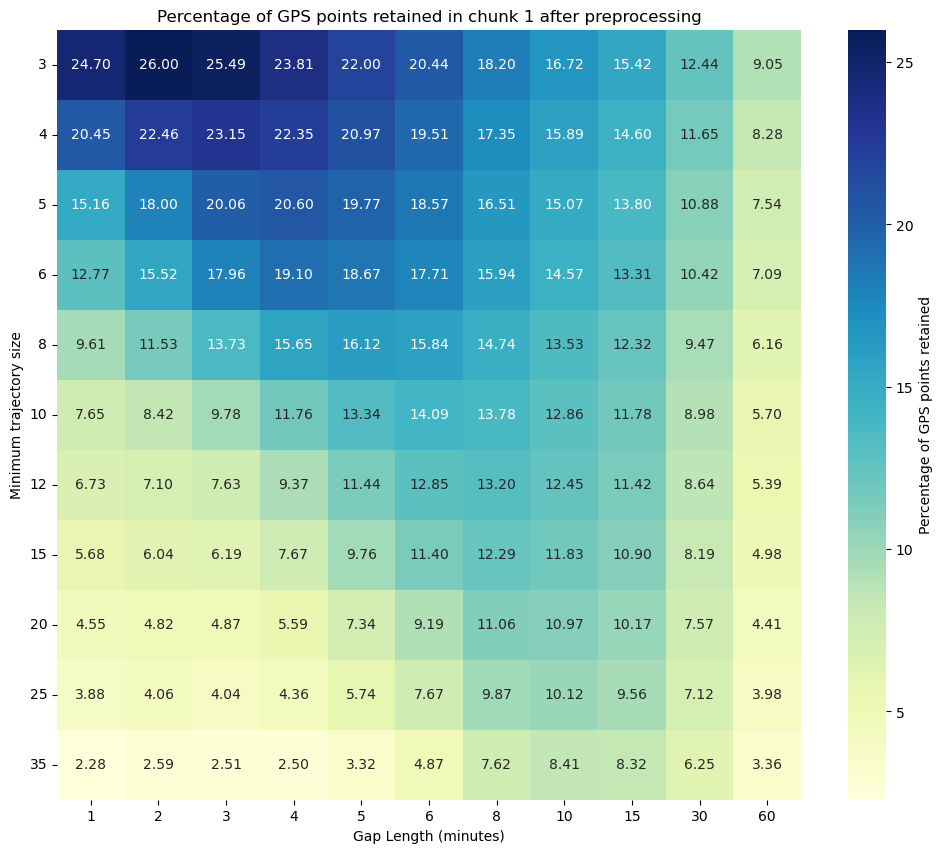

In [24]:
plt.figure(figsize=(12, 10))
heatmap_data = percent_matrix.pivot_table(index="min_traj", columns="gap_length",
                             values="percentage_gps")
sns.heatmap(
    heatmap_data,
    annot=True,        # show the percentage in each cell
    fmt=".2f",         # format numbers with 1 decimal place
    cmap="YlGnBu",     # color map
    cbar_kws={'label': 'Percentage of GPS points retained'}
)

plt.title("Percentage of GPS points retained in chunk 1 after preprocessing")
plt.xlabel("Gap Length (minutes)")
plt.ylabel("Minimum trajectory size")
plt.yticks(rotation=0)  # keep y-axis labels horizontal

#plt.savefig(f'Select_GPS_Preprocessing_Params/Heatmap_conserved_gps_mean_time_filt.png')

plt.show()

#percent_matrix.to_csv(f'Select_GPS_Preprocessing_Params/Percantage_gps_after_preprocessing.csv')

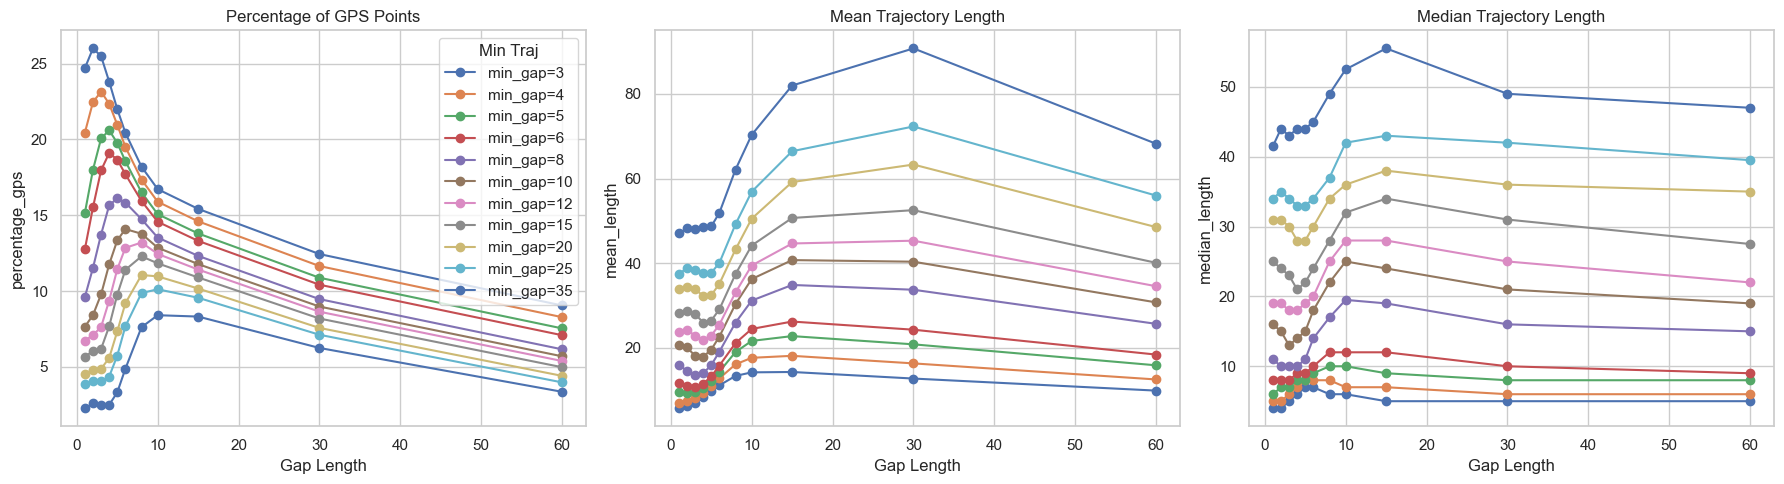

In [68]:
# Optional: use a clean seaborn style
sns.set(style="whitegrid")

# Metrics you want to plot
metrics = ['percentage_gps', 'mean_length', 'median_length']
titles = ['Percentage of GPS Points', 'Mean Trajectory Length', 'Median Trajectory Length']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# Loop through metrics and axes
for ax, metric, title in zip(axes, metrics, titles):
    # Plot each min_traj as a separate line
    for mt in percent_matrix['min_traj'].unique():
        sub = percent_matrix[percent_matrix['min_traj'] == mt]
        ax.plot(sub['gap_length'], sub[metric], marker='o', label=f"min_gap={mt}")

    ax.set_title(title)
    ax.set_xlabel('Gap Length')
    ax.set_ylabel(metric)
    if metric == 'percentage_gps':
        ax.legend(title="Min Traj")

plt.tight_layout()

#plt.savefig(f'Select_GPS_Preprocessing_Params/Min_gap_legnth_vs_params.png')

plt.show()

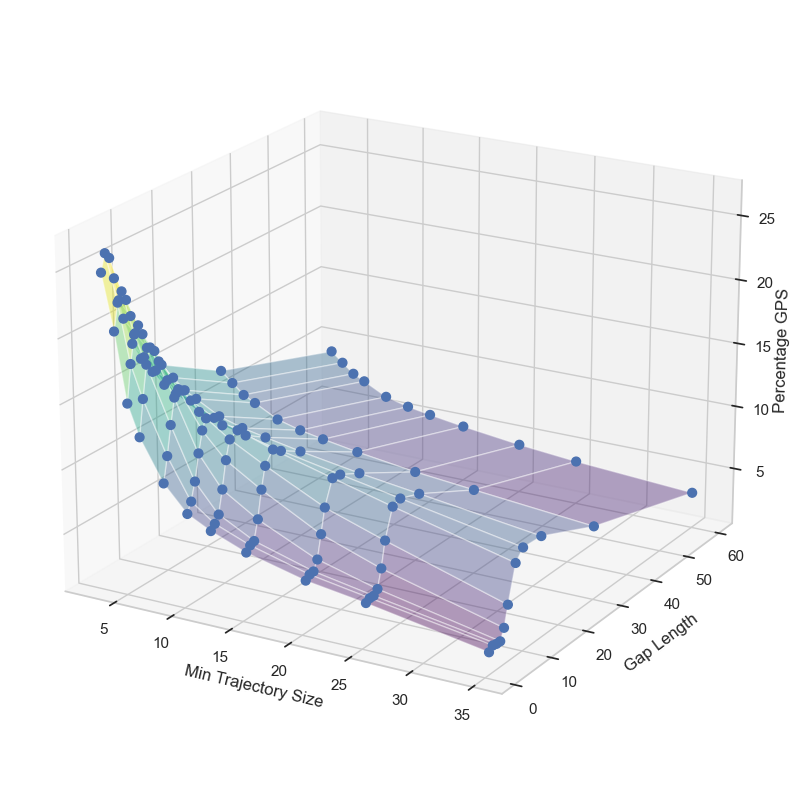

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Create pivot for surface ---
pivot = percent_matrix.pivot_table(
    index='gap_length',
    columns='min_traj',
    values='percentage_gps'
)

X, Y = np.meshgrid(pivot.columns, pivot.index)
Z = pivot.values

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# --- Plot semi-transparent surface ---
ax.plot_surface(
    X, Y, Z,
    alpha=0.4,      # transparency (0 = invisible, 1 = opaque)
    cmap = 'viridis',
    edgecolor='white'
)

# --- Plot the actual points ---
ax.scatter(
    percent_matrix['min_traj'],
    percent_matrix['gap_length'],
    percent_matrix['percentage_gps'],
    s=40,
    alpha=1
)

ax.set_ylabel('Gap Length')
ax.set_xlabel('Min Trajectory Size')
ax.set_zlabel('Percentage GPS')
ax.zaxis.labelpad=-0.7

ax.view_init(elev=20)

#plt.savefig(f'Select_GPS_Preprocessing_Params/3D_Plot_Min_Traj_Min_Gap_Length_Percent_GPS.png')

plt.show()
